# K2-18b simulations

In [1]:
# %load ~/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import astropy.units as u
import seaborn as sns
sns.set_context('talk')
import h5py

In [3]:
import astropy.constants as const

What is the star's solid angle?

$\Omega = \frac{R^2}{d^2}$

In [87]:
omega = (0.411*u.Rsun)**2/(34.0*u.pc)**2

Starfish needs the log Omega.

In [88]:
np.log10(omega.to(u.dimensionless_unscaled).value)

-19.129131274054544

In [95]:
omega.to(u.dimensionless_unscaled).value

7.427945796791263e-20

Assume an initial spot coverage of 26%.

In [89]:
np.log10(0.26*omega.to(u.dimensionless_unscaled).value)

-19.714157926083725

In [96]:
0.26*omega.to(u.dimensionless_unscaled).value

1.9312659071657283e-20

In [97]:
0.74*omega.to(u.dimensionless_unscaled).value

5.496679889625534e-20

In [90]:
np.log10(0.74*omega.to(u.dimensionless_unscaled).value)

-19.259899554323567

In [8]:
T_ambient = 3457.0 # "+/-40"

In [9]:
T_spot = 0.86*T_ambient
T_spot, T_ambient - T_spot

(2973.02, 483.98)

and $\Delta T$ spot contrast = 484 K.

We need to make "synthetic data" in this directory:
> $nubble/data/synthetic/GJ1214_synthetic.hdf5

Estimate $\log{g}$

In [10]:
grav = const.G * 0.359*u.M_sun / (0.411*u.Rsun)**2

In [11]:
logg = np.log10(grav.cgs.value)
logg

4.765478432129314

In [12]:
#! mkdir ../data/synthetic

The keys are:
> `['fls', 'masks', 'sigmas', 'wls']`

The `masks` values should all be `1`.

We need to mimic these columns.

**Only run these the very first time**

In [13]:
#! cp ../data/synthetic/trappist1_syn_wfc3.hdf5 ../data/synthetic/K2_18b_synthetic.hdf5 

In [14]:
f1 = h5py.File('../data/synthetic/K2_18b_synthetic.hdf5', mode='w')

In [15]:
list(f1.keys())

[]

In [24]:
f1.close()

Let's pick a **spectral resolution** and slit sampling:

- $R$ ~ 1000   
- 3.0 pixels per slit sampling  
- $\Delta \lambda$ = 1.1 - 1.6 $\mu$m

$$R \equiv \lambda / \delta \lambda$$

$$\delta \lambda = \lambda / R$$

In [16]:
Res = 130.0
dv = (const.c/Res).to(u.km/u.s)
samp = 2.0
del_lam = 5.0 #nm
bandwidth_nm = 1700 - 1075

nm_per_pixel = 4.65
dv

<Quantity 2306.09583077 km / s>

In [17]:
N_samples = bandwidth_nm / nm_per_pixel # = number of pixels
N_samples

134.40860215053763

So there will be about 1000 spectral resolution elements

In [18]:
wl_arr = np.arange(10750, 17000, 46) # use Angstroms now, for Starfish.

In [19]:
wl_arr.shape

(136,)

First we just need a dummy file to get Starfish to even compile!

Let's read in the simulated $S/N$ estimates:

In [20]:
df_wfc3 = pd.read_csv('../data/WFC3IR.ss.1325109_SNR_1orbit.csv')

In [21]:
df_wfc3 = df_wfc3[(df_wfc3.wavelength >10750) & (df_wfc3.wavelength <17000)].reset_index(drop=True)

In [22]:
df_wfc3.head(2)

,wavelength,SNR
0,10769.5,1387.532279
1,10816.0,1660.467990


In [25]:
f1 = h5py.File('../data/synthetic/K2_18b_synthetic.hdf5', mode='w')
f1['wls'] = df_wfc3.wavelength.values
f1['fls'] = df_wfc3.wavelength.values*0.0+4.0e-16
f1['masks'] = df_wfc3.wavelength.values.astype(int)*0+1
f1['sigmas'] = (4.0e-16/df_wfc3.SNR.values)
f1.close()

Now make a draw from the model to place into the synthetic data.

`$nubble/code/plot_specific_mix_model.py --config`

In [26]:
df = pd.read_csv('../sf/K2_18b/output/mix_emcee/run01/spec_config.csv')

In [27]:
df.head()

,wl,data,model_composite,model_cool50,model_hot50
0,10769.5,4.000000e-16,1.271320e-14,2.215508e-15,1.049769e-14
1,10816.0,4.000000e-16,1.269183e-14,2.237977e-15,1.045386e-14
2,10862.5,4.000000e-16,1.271430e-14,2.254361e-15,1.045994e-14
3,10909.0,4.000000e-16,1.271351e-14,2.256368e-15,1.045715e-14
4,10955.5,4.000000e-16,1.266499e-14,2.243339e-15,1.042165e-14


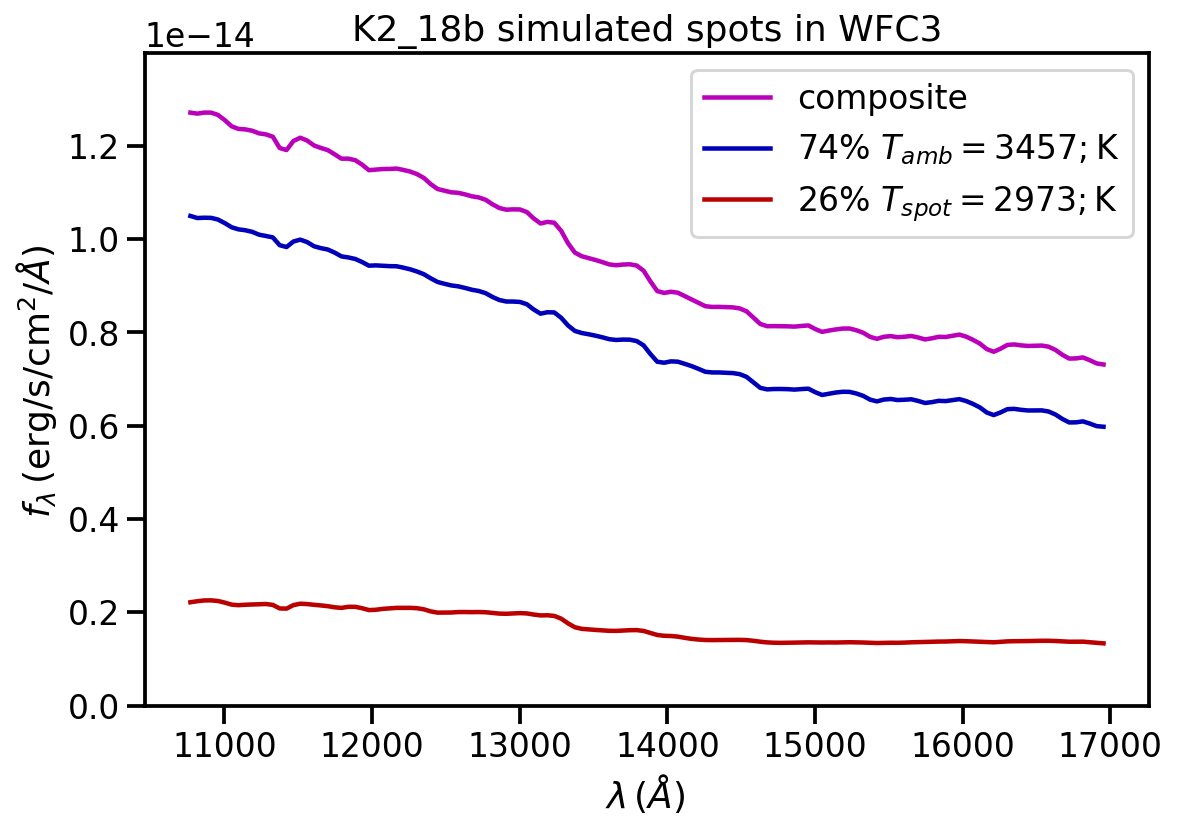

In [29]:
plt.figure(figsize=(9,6))
plt.plot(df.wl, df.model_composite, color='#BB00BB', label='composite')
plt.plot(df.wl, df.model_hot50, color='#0000BB',label = '74% $T_{amb}=3457;$K') 
plt.plot(df.wl, df.model_cool50, color='#BB0000', label = '26% $T_{spot}=2973;$K')
ymax = df.model_composite.max()*1.1
plt.ylim(0, ymax)
plt.xlabel('$\lambda \, (\AA)$ ')
plt.ylabel('$f_\lambda \, (\mathrm{erg/s/cm}^2 / \AA)$ ')
plt.title('K2_18b simulated spots in WFC3');
plt.legend(loc='best')
plt.savefig('../figures/K2_18b_sim.png', dpi=300, bbox_inches='tight')

Resave the composite spectrum to the input synthetic spectrum, with a $300 \; S/N$ noise draw:

In [30]:
noise_scale = df.model_composite/df_wfc3.SNR

In [31]:
noise_draw = np.random.normal(0, noise_scale, size=len(noise_scale))

In [32]:
noised_signal = df.model_composite + noise_draw

## Resave the synthetic spectrum with white noise.

In [33]:
f1 = h5py.File('../data/synthetic/K2_18b_synthetic.hdf5', mode='w')
f1['wls'] = df.wl.values
f1['fls'] = noised_signal.values
f1['masks'] = noised_signal.values.astype(int)*0+1
f1['sigmas'] = noise_scale.values
f1.close()

## Check again!

In [187]:
df = pd.read_csv('../sf/K2_18b/output/mix_emcee/run01/spec_config.csv')

In [188]:
CC = np.load('../sf/K2_18b/output/mix_emcee/run01/CC.npy')

Made with these params:
```yaml
  "l": 1200.0,
  "logAmp": -17.5,
  "sigAmp": 1.0

```

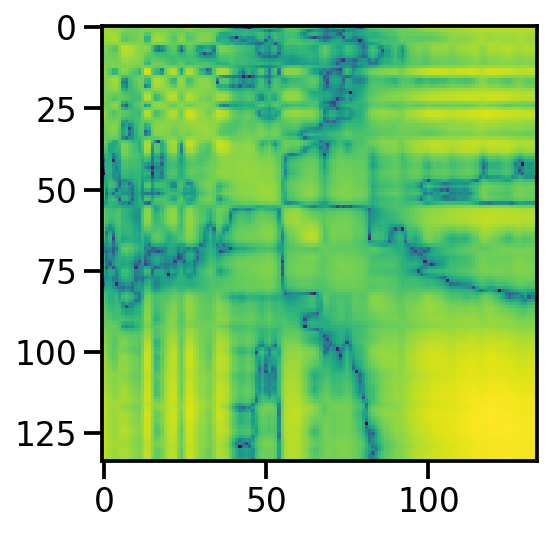

In [117]:
plt.imshow(np.log10(np.abs(CC)))

In [118]:
n_pix = len(df.model_composite)

In [119]:
correlated_noise = np.random.multivariate_normal(np.zeros(n_pix), CC)

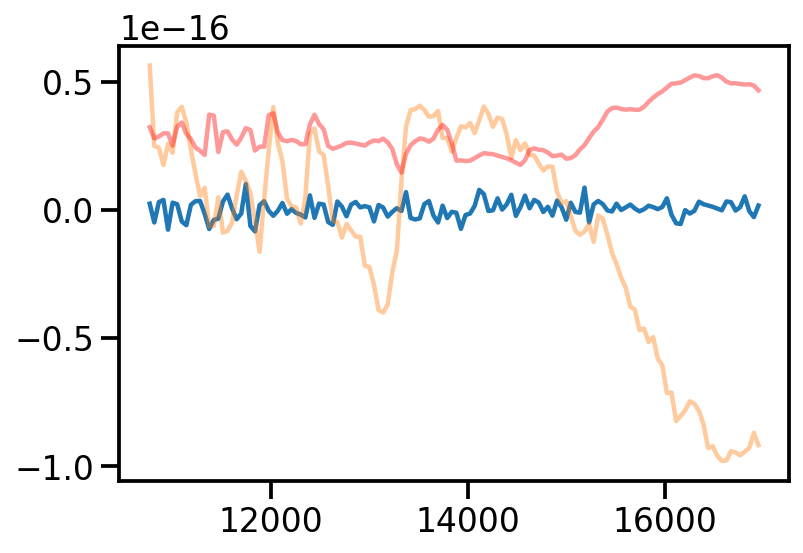

In [120]:
plt.plot(df.wl, noise_draw)
plt.plot(df.wl, correlated_noise, alpha=0.4)
plt.plot(df.wl, np.sqrt(CC.diagonal(0)), color='r',alpha=0.4)

In [121]:
np.median(df.model_composite)/np.std(correlated_noise)

394.2827081396977

In [122]:
final_output = np.random.multivariate_normal(df.model_composite, CC)

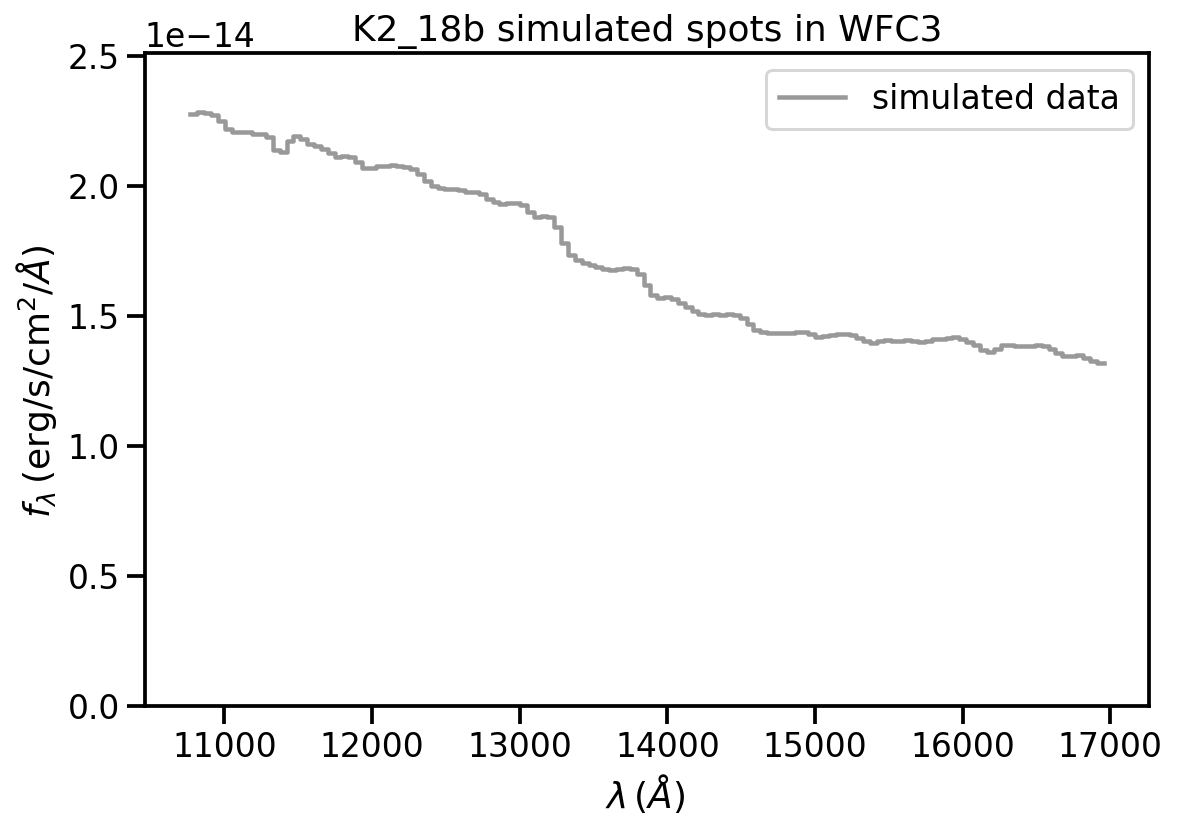

In [124]:
plt.figure(figsize=(9,6))
plt.step(df.wl, final_output, color='k', label='simulated data', alpha=0.4)
#plt.plot(df.wl, df.model_composite, color='#BB00BB', label='composite model', alpha=0.8, lw=1)
#plt.plot(df.wl, df.model_hot50, color='#0000BB',label = '74% $T_{amb}=3457;$K', lw=1) 
#plt.plot(df.wl, df.model_cool50, color='#BB0000', label = '26% $T_{spot}=2973;$K', lw=1)
ymax = df.model_composite.max()*1.1
plt.ylim(0, ymax)
plt.xlabel('$\lambda \, (\AA)$ ')
plt.ylabel('$f_\lambda \, (\mathrm{erg/s/cm}^2 / \AA)$ ')
plt.title('K2_18b simulated spots in WFC3');
plt.legend(loc='best')
plt.savefig('../figures/K2_18b_sim_wfc3.png', dpi=300, bbox_inches='tight')

In [81]:
! open ../figures/

## Save it!

In [44]:
f1 = h5py.File('../data/synthetic/K2_18b_synthetic.hdf5', mode='w')
f1['wls'] = df.wl.values
f1['fls'] = final_output
f1['masks'] = noised_signal.values.astype(int)*0+1
f1['sigmas'] = noise_scale.values
f1.close()

## Simulate TLSE

In [219]:
df = pd.read_csv('../sf/K2_18b/output/mix_emcee/run01/spec_config.csv')

In [220]:
omega_star = omega.to(u.dimensionless_unscaled).value
np.log10(omega_star)

-19.129131274054544

In [221]:
f_spot = 0.40
f_phot = 1-f_spot
f_spot, f_phot

(0.4, 0.6)

In [222]:
omega_phot = f_phot * omega_star
omega_spot = f_spot * omega_star
logOmega  = np.log10(omega_phot)
logOmega2 = np.log10(omega_spot)

In [223]:
logOmega, logOmega2

(-19.3509800236709, -19.52707128272658)

In [224]:
planet_solid_angle = (2.279*u.R_earth / (34.0*u.pc))**2
planet_solid_angle = planet_solid_angle.to(u.dimensionless_unscaled).value

planet_solid_angle = planet_solid_angle*np.ones(len(df.wl))

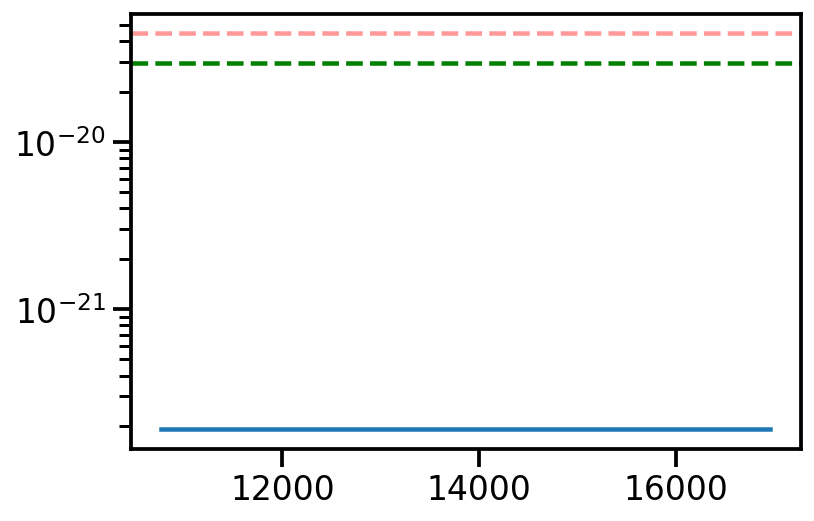

In [225]:
plt.plot(df.wl, planet_solid_angle)
plt.axhline(omega_phot, color='r', alpha=0.4, linestyle='dashed')
plt.axhline(omega_spot, color='g', linestyle='dashed')
plt.yscale('log')

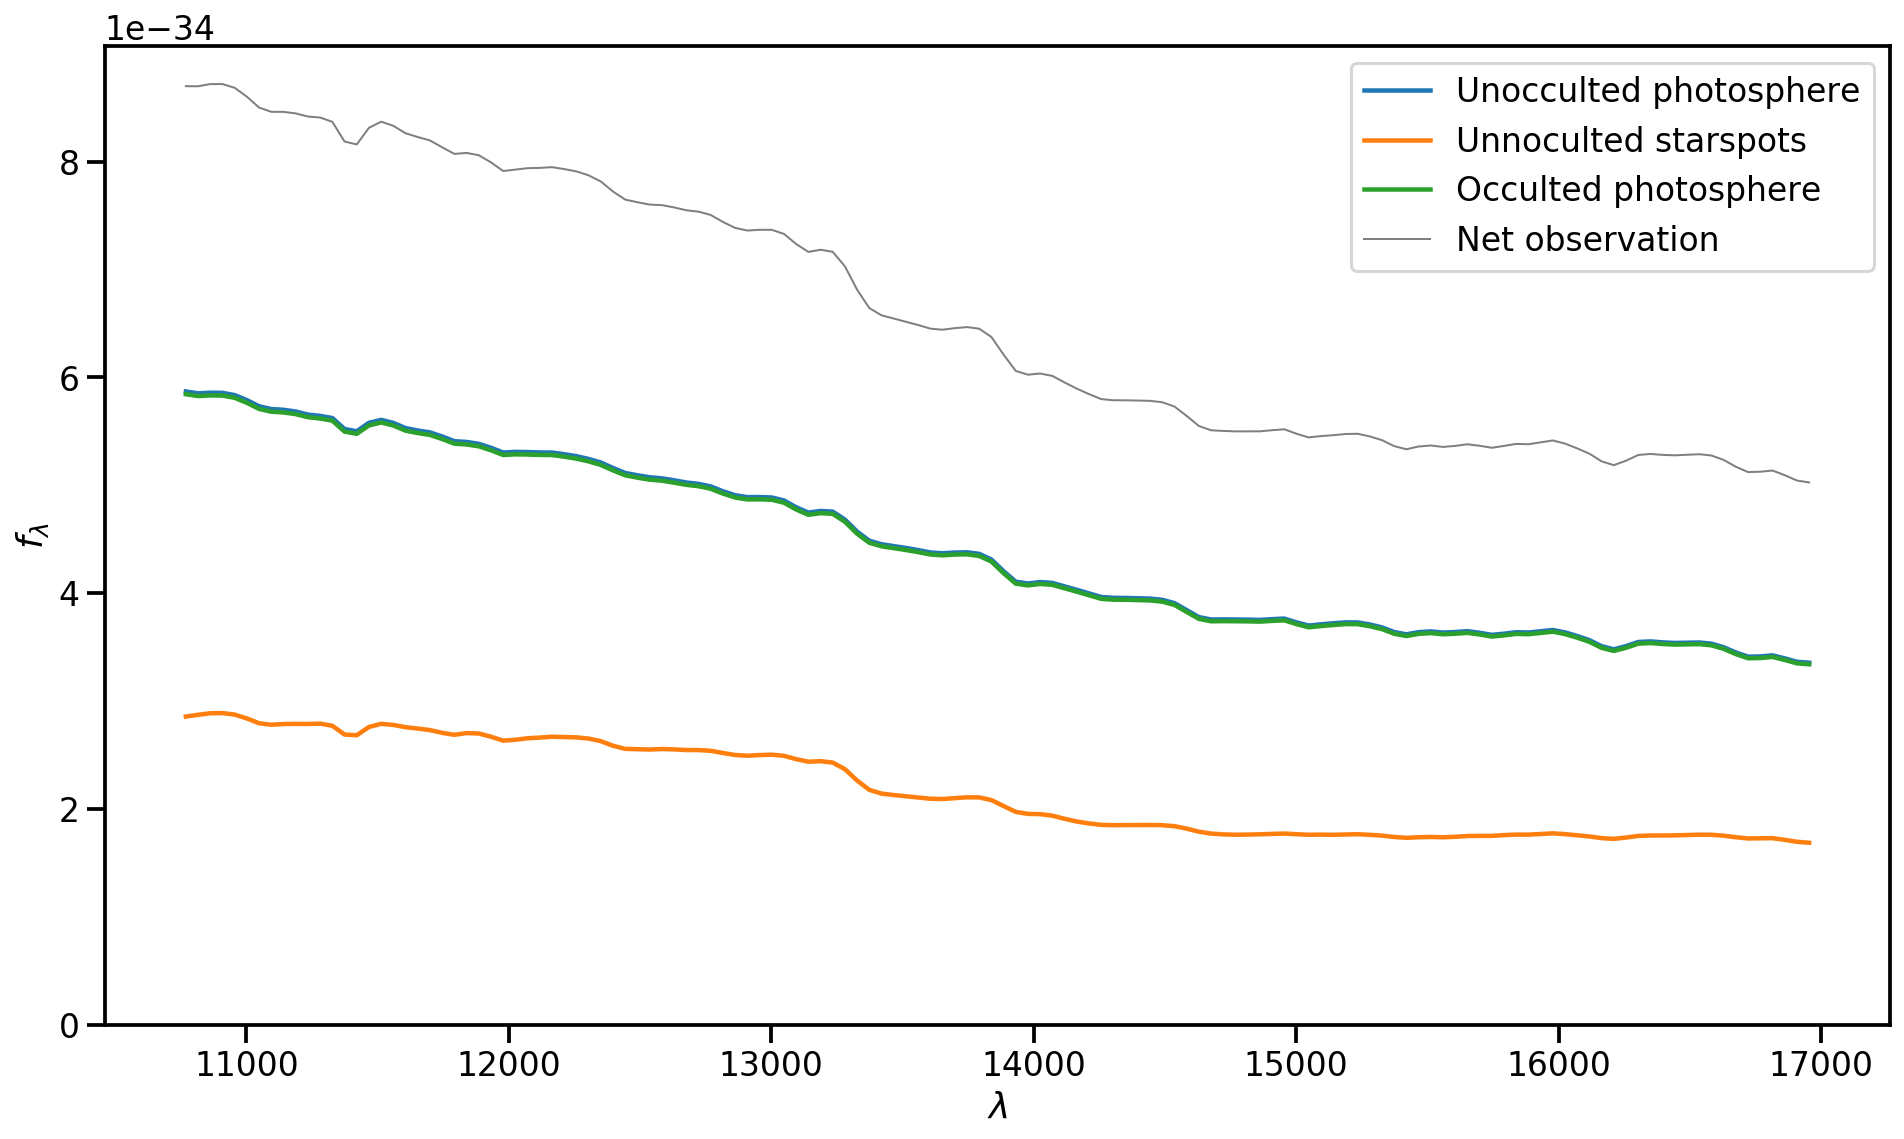

In [226]:
plt.figure(figsize=(16,9))
plt.plot(df.wl, omega_phot*df.model_hot50, label='Unocculted photosphere')
plt.plot(df.wl, omega_spot*df.model_cool50, label='Unnoculted starspots')
plt.plot(df.wl, (omega_phot-planet_solid_angle)*df.model_hot50, label='Occulted photosphere')
plt.plot(df.wl, (omega_phot-planet_solid_angle)*df.model_hot50 + omega_spot*df.model_cool50, 'k-', alpha=0.5, lw=1,
         label='Net observation')
#plt.plot(df.wl, df.data, 'k.', alpha=0.5, label='Synthetic data')
plt.ylim(0)

plt.xlabel('$\lambda$')
plt.ylabel('$f_\lambda$')

plt.legend(loc='best');
plt.savefig('K2_18b_demo_1.png', bbox_inches='tight', dpi=300)

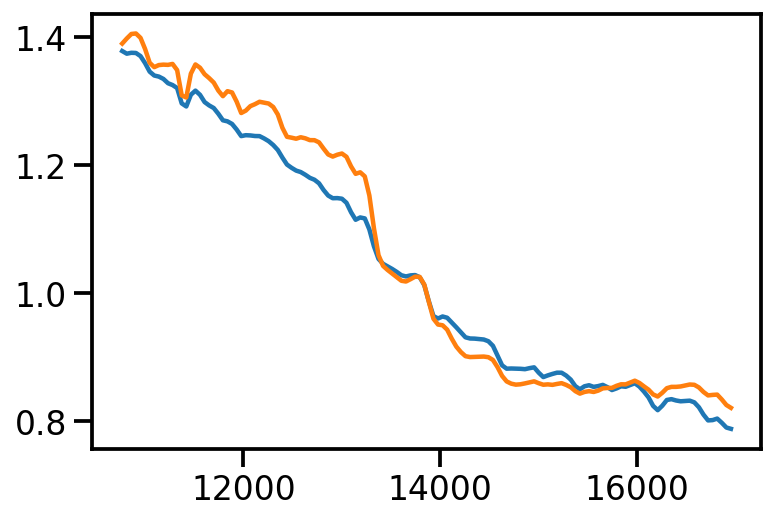

In [234]:
plt.plot(df.wl, df.model_hot50/df.model_hot50.median(), label='Unocculted photosphere')
plt.plot(df.wl, df.model_cool50/df.model_cool50.median(), label='Unnoculted starspots')

In [227]:
in_transit = (omega_phot-planet_solid_angle)*df.model_hot50 + omega_spot*df.model_cool50
out_of_transit = (omega_phot)*df.model_hot50 + omega_spot*df.model_cool50

In [228]:
rp_r_star_squared_true = planet_solid_angle/omega_star

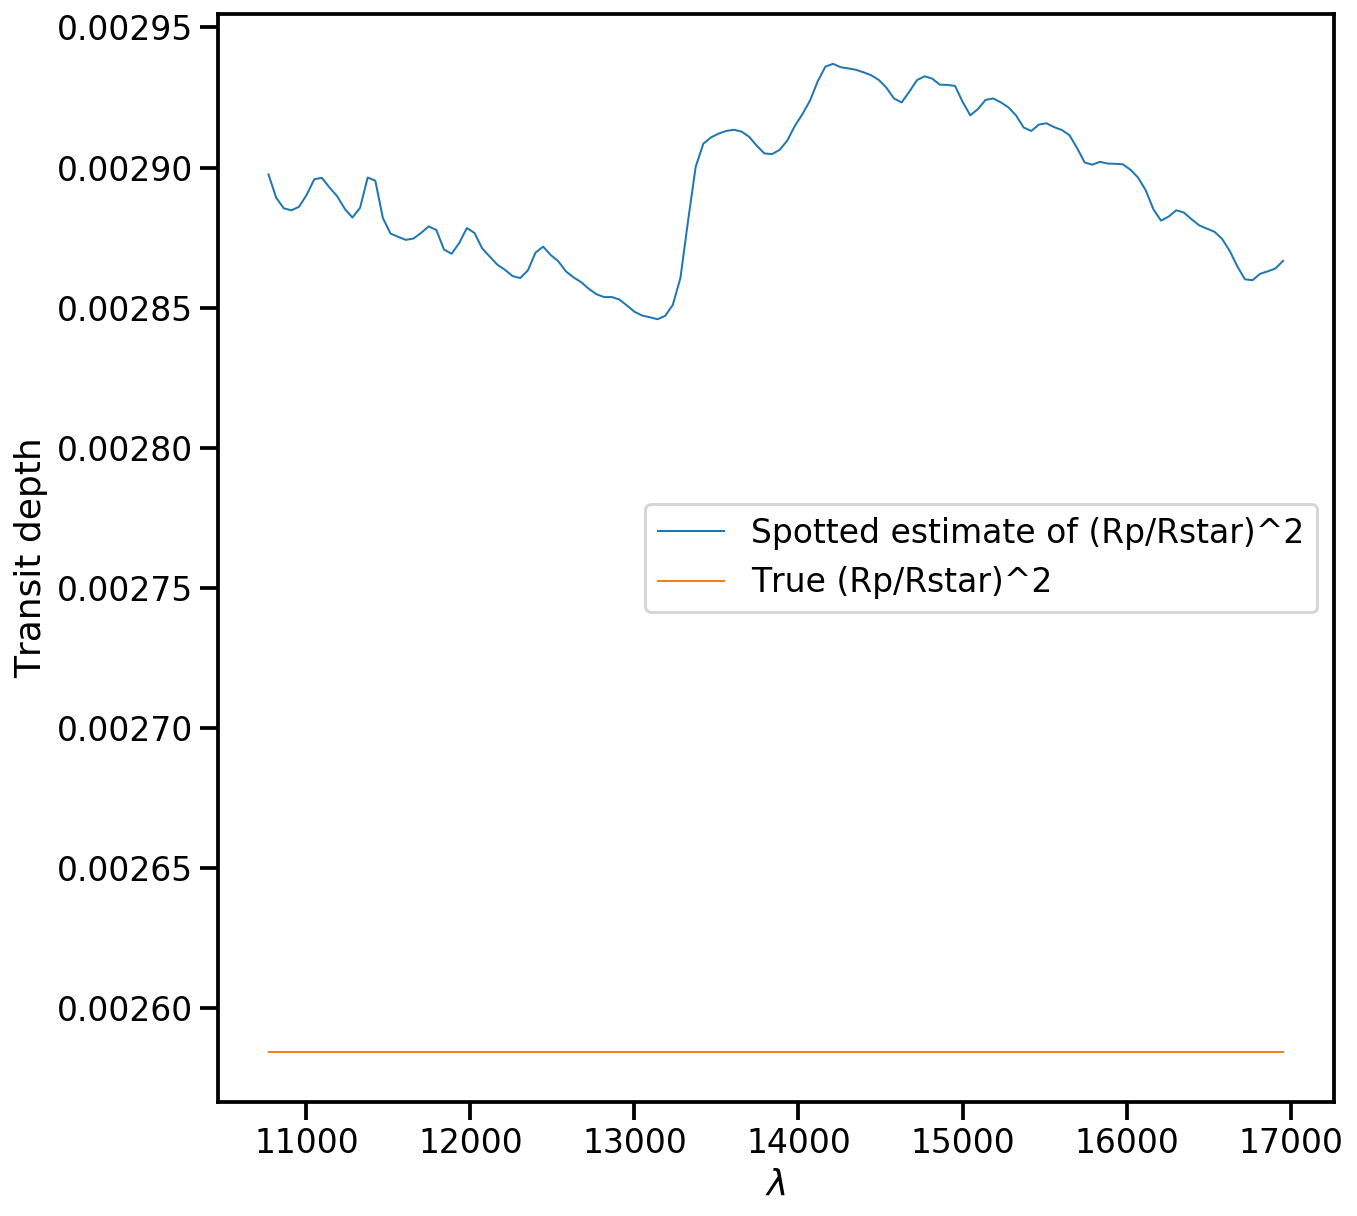

In [229]:
plt.figure(figsize=(10, 10))
plt.plot(df.wl, (out_of_transit - in_transit)/out_of_transit, lw=1, label='Spotted estimate of (Rp/Rstar)^2')

plt.plot(df.wl, rp_r_star_squared_true, lw=1, label='True (Rp/Rstar)^2')
plt.legend(loc='best')
#plt.ylim(0.013, 0.015)
plt.xlabel('$\lambda$')
plt.ylabel('Transit depth')
plt.legend(loc='best')
plt.savefig('K2_18b_demo2.png', bbox_inches='tight', dpi=300)

Read in the data from Table 1 of Tsiaras et al 2019.

In [230]:
df_K2_18b_HST = pd.read_csv('../data/K2_18b_hst.csv')

In [231]:
df_K2_18b_HST['lam_center'] = (df_K2_18b_HST.lam1 + df_K2_18b_HST.lam2)/2

In [232]:
df_K2_18b_HST['delta_ppm'] = df_K2_18b_HST['rp/rs (ppm)']-np.median(df_K2_18b_HST['rp/rs (ppm)'])

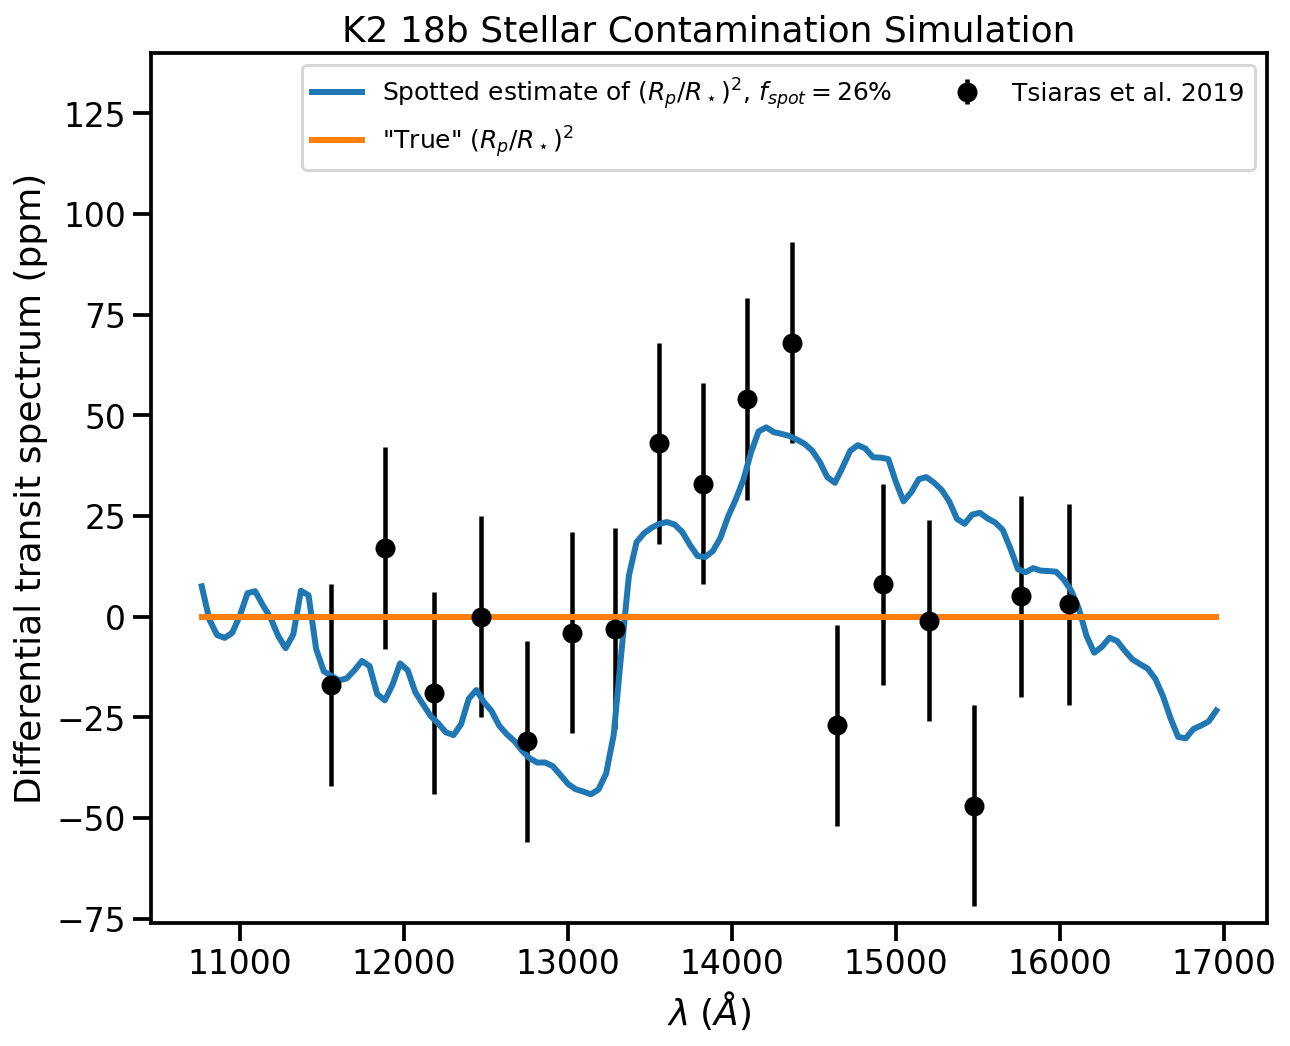

In [233]:
spotted_est_abs = (out_of_transit - in_transit)/out_of_transit
spotted_est_ppm = (spotted_est_abs - np.median(spotted_est_abs))*1.0e6
rp_r_star_squared_ppm = (rp_r_star_squared_true-np.median(rp_r_star_squared_true))*1.0e6

plt.figure(figsize=(10,8))
plt.plot(df.wl, spotted_est_ppm, lw=3, label='Spotted estimate of ($R_p/R_\star)^2$, $f_{spot}=26$%')
plt.plot(df.wl, rp_r_star_squared_ppm, lw=3, label='"True" ($R_p/R_\star)^2$')
#plt.ylim(0)

#plt.plot(df_K2_18b_HST.lam_center*10000, df_K2_18b_HST.delta_ppm, 'ko')
plt.errorbar(df_K2_18b_HST.lam_center*10000, df_K2_18b_HST.delta_ppm,
             yerr=25, fmt='ko', label = 'Tsiaras et al. 2019')

plt.legend(loc='best', fontsize='x-small', ncol=2)
plt.xlabel('$\lambda \; (Å)$')
plt.ylim(-76, 140)
plt.ylabel('Differential transit spectrum (ppm)')
plt.title('K2 18b Stellar Contamination Simulation')
plt.savefig('K2_18b_TLSE_gully.png', bbox_inches='tight', dpi=300)

In [218]:
! open .